## Importing Libraries

In [4]:
# importing core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import shap


from sklearn.model_selection import (
    train_test_split, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score, learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve, auc,
    hamming_loss, roc_auc_score
)

from xgboost import XGBClassifier

### Loading the final CSV data file

In [6]:
womens_cmr_df = pd.read_csv('final_cmr_data.csv')

### Initial Shape and structure checks

In [8]:
print(womens_cmr_df.head())

   tgt_high_chol  tgt_diabetes  tgt_high_glucose  tgt_high_bp  RIDAGEYR  \
0            0.0           0.0               NaN          NaN        66   
1            0.0           NaN               0.0          0.0        66   
2            0.0           0.0               NaN          0.0        75   
3            0.0           1.0               NaN          NaN        54   
4            0.0           0.0               0.0          0.0        60   

   INDFMPIR  BMXBMI  BMXWAIST  BPXSY2  BPXDI2  LBDTCSI  LBDHDDSI  LBDGLUSI  \
0      0.82    31.7     101.8     122      72     4.06      1.55      5.66   
1      1.63    23.7      88.2     138      78     5.40      2.28      6.77   
2      0.41    38.9     113.0     118      66     4.55      1.68      5.66   
3      1.86    39.9     118.4     122      72     5.95      1.09      5.66   
4      3.04    35.9     113.2     136      66     3.15      1.16      5.77   

  DMDEDUC2 DMDMARTL            RIDRETH3 SMQ020   drinker_status PAQ665  
0      

In [9]:
print(womens_cmr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tgt_high_chol     2560 non-null   float64
 1   tgt_diabetes      2777 non-null   float64
 2   tgt_high_glucose  1262 non-null   float64
 3   tgt_high_bp       2522 non-null   float64
 4   RIDAGEYR          2867 non-null   int64  
 5   INDFMPIR          2867 non-null   float64
 6   BMXBMI            2867 non-null   float64
 7   BMXWAIST          2867 non-null   float64
 8   BPXSY2            2867 non-null   int64  
 9   BPXDI2            2867 non-null   int64  
 10  LBDTCSI           2867 non-null   float64
 11  LBDHDDSI          2867 non-null   float64
 12  LBDGLUSI          2867 non-null   float64
 13  DMDEDUC2          2867 non-null   object 
 14  DMDMARTL          2867 non-null   object 
 15  RIDRETH3          2867 non-null   object 
 16  SMQ020            2867 non-null   object 


In [10]:
print(womens_cmr_df.describe())

       tgt_high_chol  tgt_diabetes  tgt_high_glucose  tgt_high_bp  \
count    2560.000000   2777.000000       1262.000000  2522.000000   
mean        0.114062      0.144040          0.145008     0.249405   
std         0.317949      0.351194          0.352248     0.432755   
min         0.000000      0.000000          0.000000     0.000000   
25%         0.000000      0.000000          0.000000     0.000000   
50%         0.000000      0.000000          0.000000     0.000000   
75%         0.000000      0.000000          0.000000     0.000000   
max         1.000000      1.000000          1.000000     1.000000   

          RIDAGEYR     INDFMPIR       BMXBMI     BMXWAIST       BPXSY2  \
count  2867.000000  2867.000000  2867.000000  2867.000000  2867.000000   
mean     51.172654     2.437091    30.198884    98.743948   125.522846   
std      17.698111     1.495485     7.830785    16.308510    20.274763   
min      20.000000     0.000000    14.200000    57.900000    84.000000   
25%     

In [11]:
print(womens_cmr_df.shape)

(2867, 19)


## Final Pre-processing

In [13]:
# identifying target columns
main_target_cols = ['tgt_high_chol', 'tgt_diabetes', 'tgt_high_bp']

In [14]:
# dropping the high glucose column temporarily
womens_cmr_df.drop(columns=['tgt_high_glucose'], inplace=True)

In [15]:
# dropping any rows that have a missing value in any  of the main target columns
womens_cmr_df.dropna(subset= main_target_cols, inplace=True)

In [16]:
# print the shape of the data after dropping rows to see the impact
print(f'Shape after dropping NA targets: {womens_cmr_df.shape}')

Shape after dropping NA targets: (2301, 18)


### Encoding categorical variables

In [18]:
# identifing all categorical columns that need to be encoded
cat_cols = ['DMDEDUC2', 'DMDMARTL', 'RIDRETH3', 'SMQ020', 'drinker_status', 'PAQ665']

In [19]:
# using pandas get_dummies to perform one-hot encoding
# drop_first=True is used to avoid multicollinearity between the new dummy columns
womens_cmr_df_encoded = pd.get_dummies(womens_cmr_df, columns=cat_cols, drop_first=True)

In [20]:
# printing the first few rows and the new shape to see the changes
print('\nData after one-hot encoding:')
print(womens_cmr_df_encoded.head())
print(f'\nNew shape of the data: {womens_cmr_df_encoded.shape}')


Data after one-hot encoding:
   tgt_high_chol  tgt_diabetes  tgt_high_bp  RIDAGEYR  INDFMPIR  BMXBMI  \
2            0.0           0.0          0.0        75      0.41    38.9   
4            0.0           0.0          0.0        60      3.04    35.9   
5            0.0           0.0          0.0        60      2.07    23.8   
6            0.0           0.0          0.0        67      1.85    31.1   
7            0.0           0.0          0.0        25      3.40    24.8   

   BMXWAIST  BPXSY2  BPXDI2  LBDTCSI  ...  DMDMARTL_6  DMDMARTL_Married  \
2     113.0     118      66     4.55  ...       False             False   
4     113.2     136      66     3.15  ...       False             False   
5      89.7     110      66     4.76  ...       False             False   
6     105.6     126      40     4.55  ...       False             False   
7      74.4     108      60     4.53  ...       False             False   

   RIDRETH3_Non-Hispanic Asian  RIDRETH3_Non-Hispanic Black  \
2    

### Feature Definition

In [22]:
# creating the target columns
target_cols = ['tgt_high_chol', 'tgt_diabetes', 'tgt_high_bp']

In [23]:
# added after model evaluation- identifying columns that leak information about the targets
leak_cols = ['LBDTCSI', 'BPXSY2', 'BPXDI2']

In [24]:
# creating the feature matrix X by dropping the target columns
X = womens_cmr_df_encoded.drop(columns=target_cols + leak_cols)

In [25]:
# creating the target matrix y by selecting only the target columns
y = womens_cmr_df_encoded[target_cols]

In [26]:
# printing the shapes of X and y to confirm they were created correctly
print('Shape of our feature matrix (X):', X.shape)
print('Shape of our target matrix (y):', y.shape)

Shape of our feature matrix (X): (2301, 25)
Shape of our target matrix (y): (2301, 3)


In [27]:
# display the first few rows of each to verify
print('\nFirst 5 rows of X:')
print(X.head())


First 5 rows of X:
   RIDAGEYR  INDFMPIR  BMXBMI  BMXWAIST  LBDHDDSI  LBDGLUSI  DMDEDUC2_2  \
2        75      0.41    38.9     113.0      1.68      5.66       False   
4        60      3.04    35.9     113.2      1.16      5.77       False   
5        60      2.07    23.8      89.7      2.02      5.61       False   
6        67      1.85    31.1     105.6      0.91      5.66       False   
7        25      3.40    24.8      74.4      1.84      5.66       False   

   DMDEDUC2_3  DMDEDUC2_4  DMDEDUC2_5  ...  DMDMARTL_6  DMDMARTL_Married  \
2       False        True       False  ...       False             False   
4       False       False       False  ...       False             False   
5       False        True       False  ...       False             False   
6       False       False       False  ...       False             False   
7       False       False        True  ...       False             False   

   RIDRETH3_Non-Hispanic Asian  RIDRETH3_Non-Hispanic Black  \
2        

In [28]:
print('\nFirst 5 rows of y:')
print(y.head())


First 5 rows of y:
   tgt_high_chol  tgt_diabetes  tgt_high_bp
2            0.0           0.0          0.0
4            0.0           0.0          0.0
5            0.0           0.0          0.0
6            0.0           0.0          0.0
7            0.0           0.0          0.0


In [29]:
# final check of class counts on the target data
print('\nFinal class counts for each target variable:')
for col in y.columns:
    print(f'\n--- {col} ---')
    print(y[col].value_counts())


Final class counts for each target variable:

--- tgt_high_chol ---
tgt_high_chol
0.0    2034
1.0     267
Name: count, dtype: int64

--- tgt_diabetes ---
tgt_diabetes
0.0    1981
1.0     320
Name: count, dtype: int64

--- tgt_high_bp ---
tgt_high_bp
0.0    1733
1.0     568
Name: count, dtype: int64


### Splitting Data into Training and Test Sets

In [31]:
# stratified 80/20 split with random_state=42 for reroducibility
# and strtaify=y to ensure target class proportions are the same
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
# print the shapes of the new data frames to confirm the split was successful
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (1840, 25)
Shape of X_test: (461, 25)
Shape of y_train: (1840, 3)
Shape of y_test: (461, 3)


In [33]:
# verifying stratification by checking the proportions in y_train and y_test
print('\nProportions in original y:')
print(y.mean())
print('\nProportions in y_train:')
print(y_train.mean())
print('\nProportions in y_test:')
print(y_test.mean())


Proportions in original y:
tgt_high_chol    0.116037
tgt_diabetes     0.139070
tgt_high_bp      0.246849
dtype: float64

Proportions in y_train:
tgt_high_chol    0.116304
tgt_diabetes     0.139130
tgt_high_bp      0.247283
dtype: float64

Proportions in y_test:
tgt_high_chol    0.114967
tgt_diabetes     0.138829
tgt_high_bp      0.245119
dtype: float64


## Model Training

In [35]:
# creartinng a model dictionary to hold trained models for ease of access later
models = {}

### Logistic Regression

In [37]:
# defining the logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight ='balanced')

In [38]:
# creating the multi-output wrapper for logistic regression
cmr_lr_model= MultiOutputClassifier(lr_model)

In [39]:
# training the model on training data
print('Training the multi-label Logistic Regression model')
cmr_lr_model.fit(X_train, y_train)

Training the multi-label Logistic Regression model


MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42))

In [40]:
# storing the trained model in the model dictionary
models['Logistic Regression'] = cmr_lr_model

### Random Forest

In [42]:
# defining random forest moodel
rf_model = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=10
)

In [43]:
# creating the multi-output wrapper for random forest
cmr_rf_model = MultiOutputClassifier(rf_model)

In [44]:
# training the model on training data.
print('\nTraining the multi-label Random Forest model')
cmr_rf_model.fit(X_train, y_train)


Training the multi-label Random Forest model


MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       min_samples_leaf=10,
                                                       n_jobs=-1,
                                                       random_state=42))

In [45]:
# storing the trained model in the model dictionary
models['Random Forest'] = cmr_rf_model

### XGBoost

In [47]:
# defining the XGBoost model
xgb_model = XGBClassifier(
    random_state=42, 
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)

In [48]:
# creating the multi-output wrapper for XGBoost
cmr_xgb_model = MultiOutputClassifier(xgb_model)

In [49]:
# training the model on the training data
print('\nTraining the multi-label XGBoost model')
cmr_xgb_model.fit(X_train, y_train)


Training the multi-label XGBoost model


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None, ...))

In [50]:
# storing the trained model in the dictionary
models['XGBoost'] = cmr_xgb_model

## Model Evaluation

In [52]:
# looping through each trained model in the models dictionary
for model_name, model in models.items():
    print(f'--- Evaluating: {model_name} ---')
    
    # making predictions on the test set 
    y_pred = model.predict(X_test)
    
    # calculating the overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Overall Accuracy: {accuracy:.4f}')
    
    # calculating the Hamming Loss
    h_loss = hamming_loss(y_test, y_pred)
    print(f'Hamming Loss: {h_loss:.4f}\n')
    
    # printing a detailed classification report
    print(classification_report(y_test, y_pred, target_names=target_cols))
    
    print('-' * 50 + '\n')

--- Evaluating: Logistic Regression ---
Overall Accuracy: 0.4599
Hamming Loss: 0.2878

               precision    recall  f1-score   support

tgt_high_chol       0.18      0.62      0.28        53
 tgt_diabetes       0.34      0.70      0.45        64
  tgt_high_bp       0.49      0.75      0.59       113

    micro avg       0.33      0.71      0.45       230
    macro avg       0.33      0.69      0.44       230
 weighted avg       0.38      0.71      0.48       230
  samples avg       0.16      0.27      0.19       230

--------------------------------------------------

--- Evaluating: Random Forest ---
Overall Accuracy: 0.5466
Hamming Loss: 0.2017

               precision    recall  f1-score   support

tgt_high_chol       0.28      0.30      0.29        53
 tgt_diabetes       0.42      0.64      0.51        64
  tgt_high_bp       0.48      0.72      0.57       113

    micro avg       0.42      0.60      0.50       230
    macro avg       0.39      0.55      0.46       230
 weig

C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-package

### Cross Validation Model Comparison

In [54]:
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    print(f'{model_name}:')
    print(f'  Mean CV F1 (Weighted): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')
    print(f'  CV Range: {cv_scores.min():.4f} - {cv_scores.max():.4f}\n')

Logistic Regression:
  Mean CV F1 (Weighted): 0.4583 (±0.0087)
  CV Range: 0.4465 - 0.4685

Random Forest:
  Mean CV F1 (Weighted): 0.4559 (±0.0225)
  CV Range: 0.4174 - 0.4770

XGBoost:
  Mean CV F1 (Weighted): 0.3092 (±0.0176)
  CV Range: 0.2800 - 0.3282



## Rerunning Logistic Regression with scaled data

In [56]:
# setting up StandardScaler
std_scaler = StandardScaler()

In [57]:
# fitting the scaler on the training data and transforming both train and test sets
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [58]:
# training a new logistic regression model on the scaled data
lr_scaled_est = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_scaled_model = MultiOutputClassifier(lr_scaled_est)

lr_scaled_model.fit(X_train_scaled, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42))

In [59]:
# evaluating the new scaled model
print('\n--- Final Evaluation: scaled Logistic Regression Model ---')
y_pred_scaled = lr_scaled_model.predict(X_test_scaled)

# Print the classification report
print('Classification Report - Scaled Model:')
print(classification_report(y_test, y_pred_scaled, target_names=target_cols))

# printing the AUC scores for comparison
print('\n--- AUC Score Comparison ---')
# calculating AUC for the scaled model
y_pred_proba_scaled = lr_scaled_model.predict_proba(X_test_scaled)
for i, target_name in enumerate(target_cols):
    auc_scaled = roc_auc_score(y_test[target_name], y_pred_proba_scaled[i][:, 1])
    print(f'AUC for {target_name} (Scaled LR): {auc_scaled:.4f}')


--- Final Evaluation: scaled Logistic Regression Model ---
Classification Report - Scaled Model:
               precision    recall  f1-score   support

tgt_high_chol       0.18      0.62      0.27        53
 tgt_diabetes       0.34      0.70      0.45        64
  tgt_high_bp       0.49      0.74      0.59       113

    micro avg       0.33      0.70      0.45       230
    macro avg       0.33      0.69      0.44       230
 weighted avg       0.37      0.70      0.48       230
  samples avg       0.16      0.27      0.19       230


--- AUC Score Comparison ---
AUC for tgt_high_chol (Scaled LR): 0.6634
AUC for tgt_diabetes (Scaled LR): 0.8359
AUC for tgt_high_bp (Scaled LR): 0.8314


C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Feature Importance: MultiOutput Model (Random Forest)

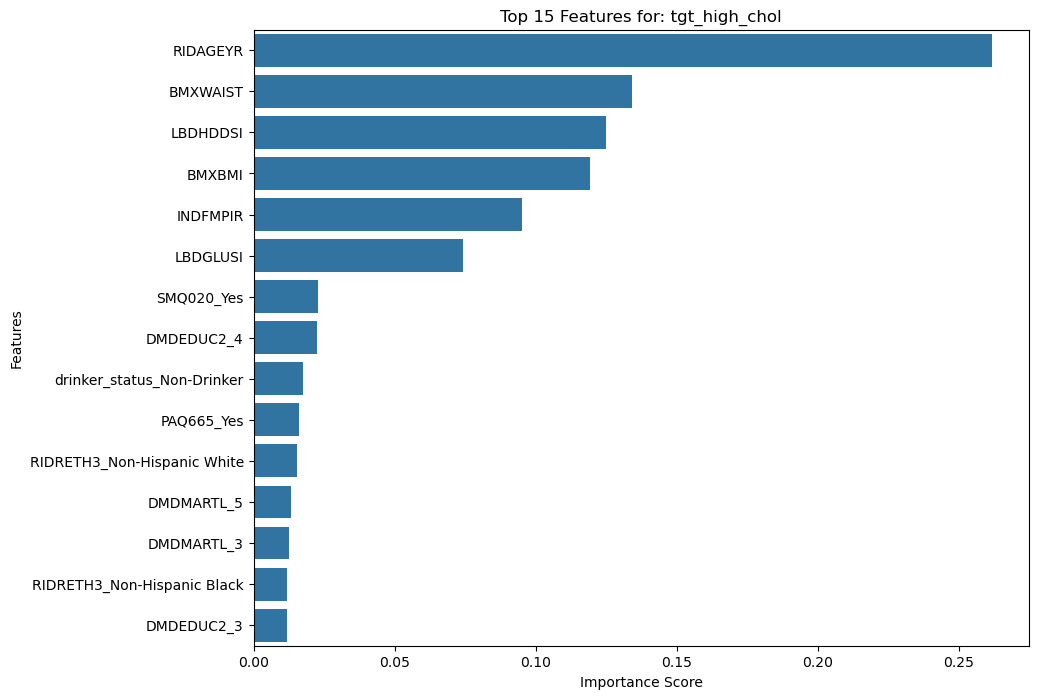

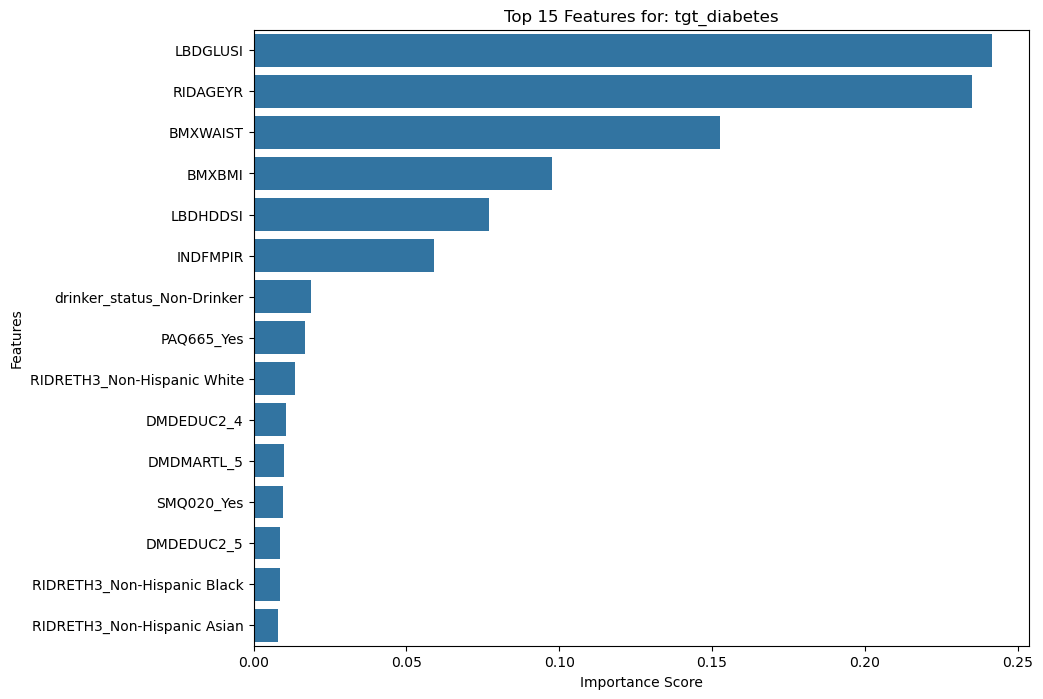

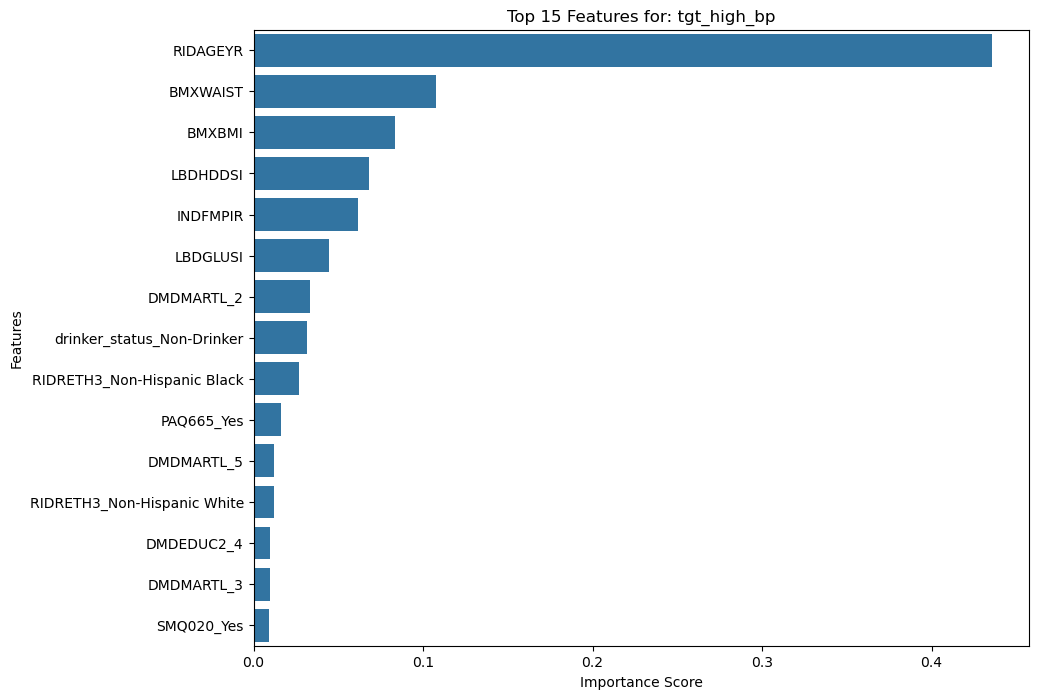

In [61]:
# loop through each of the 3 estimators (one for each target) in our multi-output model
for i, target_name in enumerate(target_cols):
    
    individual_model = cmr_rf_model.estimators_[i]
    
    importances = individual_model.feature_importances_
    
    feature_importances = pd.Series(importances, index=X_train.columns)
    
    # sorting the features by importance
    sorted_importances = feature_importances.sort_values(ascending=False)
    
    # creating a plot for the current target
    plt.figure(figsize=(10, 8))
    sns.barplot(x=sorted_importances.head(15), y=sorted_importances.head(15).index)
    plt.title(f'Top 15 Features for: {target_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.savefig(f'feature_importance_{target_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Hyperparameter Tuning

### Random Forest

In [64]:
# defining the parameter grid
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_leaf': [1, 2, 4]
}

In [65]:
# defining the cross-validation strategy
# StratifiedShuffleSplit to ensure  cross-validation folds are properly balanced
# 5 splits each with a 20% test set.
cv_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [66]:
# setting up the model for tuning
rf_for_tuning = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
multi_target_rf_for_tuning = MultiOutputClassifier(rf_for_tuning)

In [67]:
# setting up GridSearchCV object
grid_search = GridSearchCV(
    estimator=multi_target_rf_for_tuning,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv_strategy,
    n_jobs=-1, 
    verbose=2  
)

In [68]:
# running the Grid Search on the training data
grid_search.fit(X_train, y_train)
final_rf_model = grid_search.best_estimator_ 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [69]:
# printing the best parameters found
print('\nBest parameters found by grid search:')
print(grid_search.best_params_)


Best parameters found by grid search:
{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 200}


### XGBoost

In [71]:
# defining the XGB Parameter Grid
xgb_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 6],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__reg_alpha': [0, 0.1],
    'estimator__reg_lambda': [1, 1.5],
    'estimator__subsample': [0.9, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

In [72]:
xgb_for_tuning = XGBClassifier(random_state=42, n_jobs=-1, objective='binary:logistic', 
                               eval_metric='logloss', verbosity=0)
multi_target_xgb_for_tuning = MultiOutputClassifier(xgb_for_tuning)

In [73]:
xgb_grid_search = GridSearchCV(
    estimator=multi_target_xgb_for_tuning,
    param_grid=xgb_param_grid,
    scoring='f1_weighted',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=0
)

print('Tuning XGBoost...')
xgb_grid_search.fit(X_train, y_train)
final_xgb_tuned_model = xgb_grid_search.best_estimator_

Tuning XGBoost...


In [74]:
# updating model dictionary
models['XGBoost (Tuned)'] = final_xgb_tuned_model

In [75]:
# updating corss-validation comparison
print('\nFinal Cross-Validation Results:')
cv_results = {
    'Logistic Regression': 0.4583,
    'Random Forest': 0.4559,
    'XGBoost (Original)': 0.3092,
    'XGBoost (Tuned)': xgb_grid_search.best_score_
}

for model_name, score in cv_results.items():
    print(f'{model_name}: {score:.4f}')


Final Cross-Validation Results:
Logistic Regression: 0.4583
Random Forest: 0.4559
XGBoost (Original): 0.3092
XGBoost (Tuned): 0.3418


## Final Model Evaluation

In [77]:
# final model evaluation for both tuned models
final_models_to_evaluate = {
    'Tuned Random Forest': final_rf_model,
    'Tuned XGBoost': final_xgb_tuned_model
}

for model_name, model in final_models_to_evaluate.items():
    y_pred_final = model.predict(X_test)
    accuracy_final = accuracy_score(y_test, y_pred_final)
    h_loss_final = hamming_loss(y_test, y_pred_final)
    
    print(f'{model_name}: Accuracy {accuracy_final:.4f}, Hamming Loss {h_loss_final:.4f}')

Tuned Random Forest: Accuracy 0.5748, Hamming Loss 0.1800
Tuned XGBoost: Accuracy 0.6377, Hamming Loss 0.1490


### Classification Report

In [79]:
# printing a detailed classification report
for model_name, model in final_models_to_evaluate.items():
    y_pred_final = model.predict(X_test)
    accuracy_final = accuracy_score(y_test, y_pred_final)
    h_loss_final = hamming_loss(y_test, y_pred_final)
    
    print(f'{model_name}: Accuracy {accuracy_final:.4f}, Hamming Loss {h_loss_final:.4f}')
    print(classification_report(y_test, y_pred_final, target_names=target_cols))
    print()  # Just a blank line separator

Tuned Random Forest: Accuracy 0.5748, Hamming Loss 0.1800
               precision    recall  f1-score   support

tgt_high_chol       0.20      0.13      0.16        53
 tgt_diabetes       0.50      0.48      0.49        64
  tgt_high_bp       0.51      0.64      0.56       113

    micro avg       0.46      0.48      0.47       230
    macro avg       0.40      0.42      0.41       230
 weighted avg       0.43      0.48      0.45       230
  samples avg       0.19      0.19      0.18       230


Tuned XGBoost: Accuracy 0.6377, Hamming Loss 0.1490
               precision    recall  f1-score   support

tgt_high_chol       0.50      0.08      0.13        53
 tgt_diabetes       0.62      0.44      0.51        64
  tgt_high_bp       0.59      0.38      0.46       113

    micro avg       0.60      0.33      0.42       230
    macro avg       0.57      0.30      0.37       230
 weighted avg       0.58      0.33      0.40       230
  samples avg       0.14      0.13      0.13       230




C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bianc\anaconda3\Lib\site-package

### Learning Curve Analysis

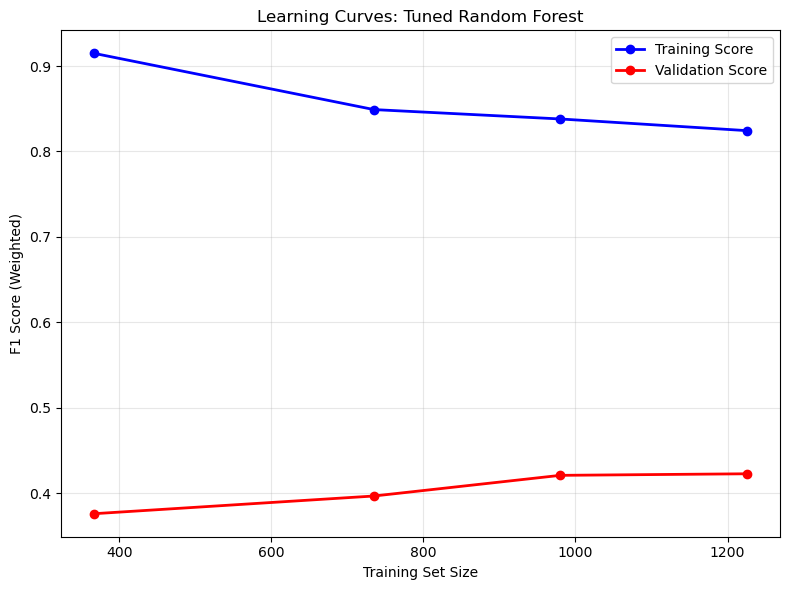

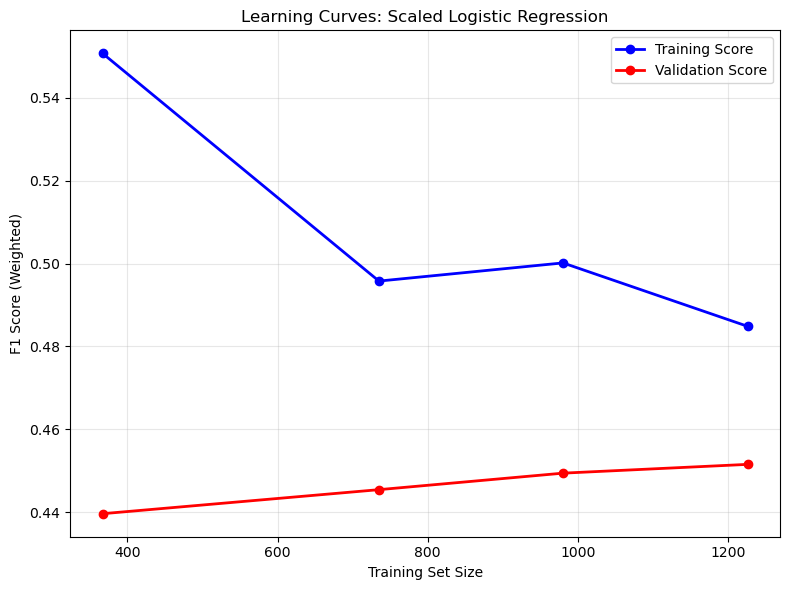

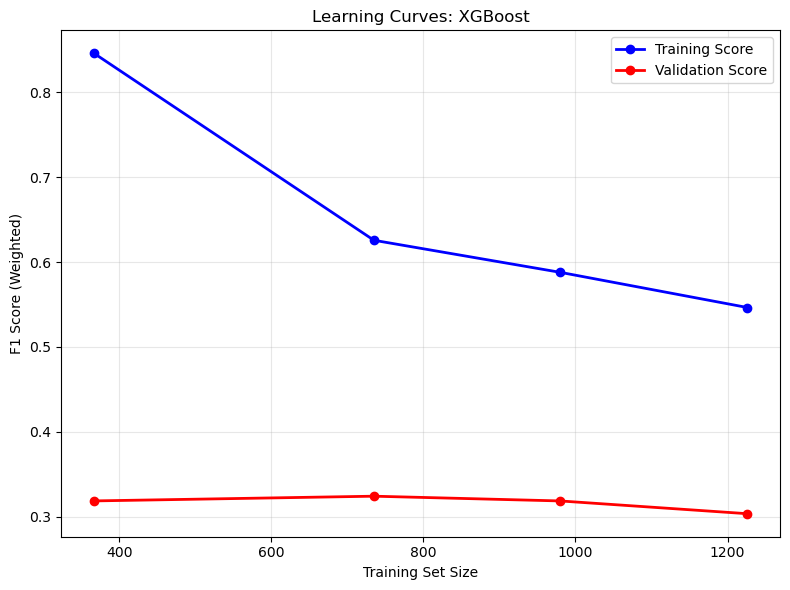

In [81]:
# learning curve analyis for final models 
def plot_simple_learning_curves(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=3, train_sizes=[0.3, 0.6, 0.8, 1.0], 
        scoring='f1_weighted', n_jobs=-1
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', 
             label='Training Score', color='blue', linewidth=2)
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', 
             label='Validation Score', color='red', linewidth=2)
    
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score (Weighted)')
    plt.title(f'Learning Curves: {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
   
    clean_name = model_name.replace(' ', '_').lower()
    plt.savefig(f'learning_curves_{clean_name}.png', 
                dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='black')  
    plt.show()

# Generate learning curves
plot_simple_learning_curves(final_rf_model, X_train, y_train, 'Tuned Random Forest')
plot_simple_learning_curves(lr_scaled_model, X_train_scaled, y_train, 'Scaled Logistic Regression')
plot_simple_learning_curves(models['XGBoost'], X_train, y_train, 'XGBoost')

### Model Summary Report

In [83]:

def create_model_summary():
    print('\n' + '='*70)
    print('          CARDIOMETABOLIC RISK MODEL COMPARISON SUMMARY')
    print('='*70)
    
    print('\nCROSS-VALIDATION PERFORMANCE:')
    print(f'{'Rank':<6} {'Model':<25} {'CV F1-Score':<20} {'Status':<15}')
    print('-' * 70)
    print(f'{'1st':<6} {'Logistic Regression':<25} {'0.4583 ± 0.009':<20} {'RECOMMENDED':<15}')
    print(f'{'2nd':<6} {'Random Forest':<25} {'0.4559 ± 0.023':<20} {'Alternative':<15}')
    print(f'{'3rd':<6} {'XGBoost':<25} {'0.3092 ± 0.018':<20} {'Needs Tuning':<15}')
    
    print('\nCLINICAL RECOMMENDATIONS:')
    print('PRIMARY: Scaled Logistic Regression')
    print('   - Best performance + stability + interpretability')
    print('ALTERNATIVE: Regularised Random Forest') 
    print('   - Competitive performance after regularization')
    
    print('\nTECHNICAL SUMMARY:')
    print(f'• Dataset: {X.shape[0]:,} samples, {X.shape[1]} features')
    print(f'• Targets: {len(target_cols)} cardiometabolic conditions')
    print(f'• Validation: 5-fold CV + learning curves')
    
    print('='*70)
    print('CONCLUSION: Linear models optimal for cardiometabolic risk prediction')
    print('='*70)

create_model_summary()


          CARDIOMETABOLIC RISK MODEL COMPARISON SUMMARY

CROSS-VALIDATION PERFORMANCE:
Rank   Model                     CV F1-Score          Status         
----------------------------------------------------------------------
1st    Logistic Regression       0.4583 ± 0.009       RECOMMENDED    
2nd    Random Forest             0.4559 ± 0.023       Alternative    
3rd    XGBoost                   0.3092 ± 0.018       Needs Tuning   

CLINICAL RECOMMENDATIONS:
PRIMARY: Scaled Logistic Regression
   - Best performance + stability + interpretability
ALTERNATIVE: Regularised Random Forest
   - Competitive performance after regularization

TECHNICAL SUMMARY:
• Dataset: 2,301 samples, 25 features
• Targets: 3 cardiometabolic conditions
• Validation: 5-fold CV + learning curves
CONCLUSION: Linear models optimal for cardiometabolic risk prediction


### Saving Trained Models

In [85]:
joblib.dump(final_rf_model, 'best_rf_model.pkl')
joblib.dump(lr_scaled_model, 'scaled_lr_model.pkl') 
joblib.dump(models['XGBoost'], 'xgboost_model.pkl')
joblib.dump(std_scaler, 'feature_scaler.pkl')

print('\n✓ Models and scaler saved successfully!')


✓ Models and scaler saved successfully!


## Advanced Visualisations and Interpretations

In [87]:
# re-defining final models for
final_models = {
    'Logistic Regression': models['Logistic Regression'], # The class-weighted version
    'Tuned Random Forest': final_rf_model,
    'XGBoost': models['XGBoost'] # The baseline version
}

--- Confusion Matrices for: Logistic Regression ---


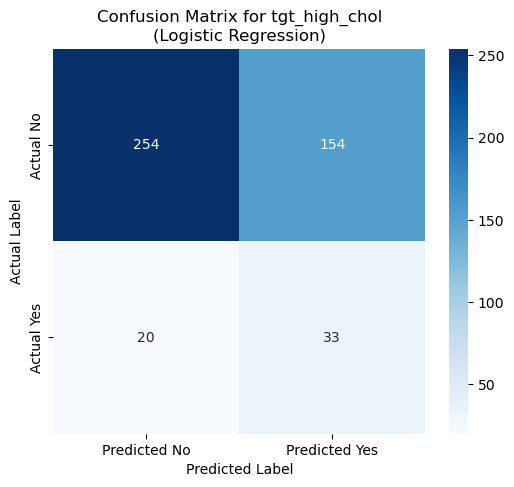

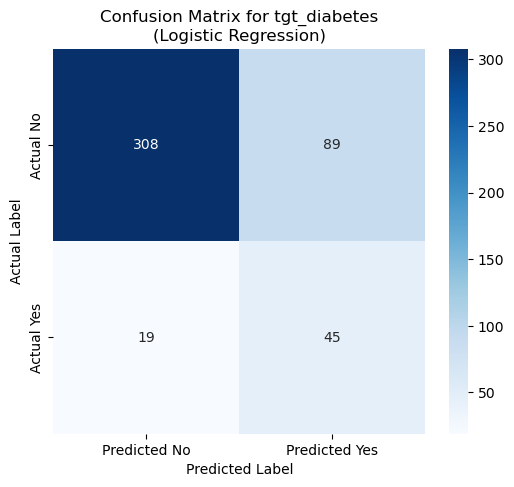

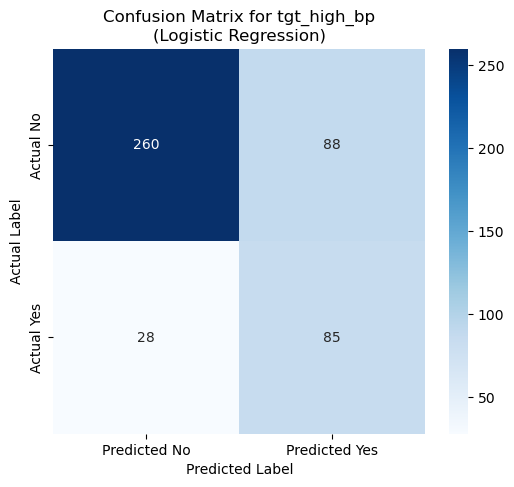

--- Confusion Matrices for: Tuned Random Forest ---


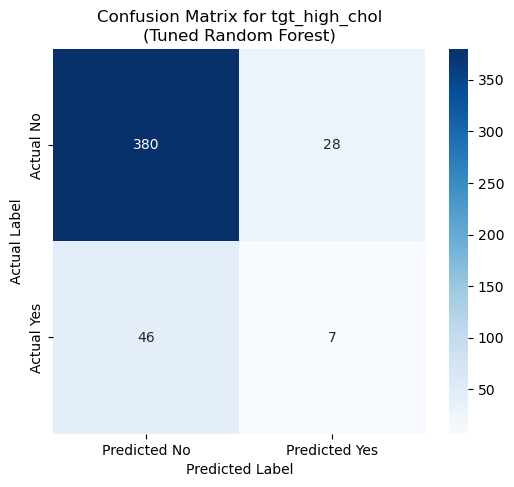

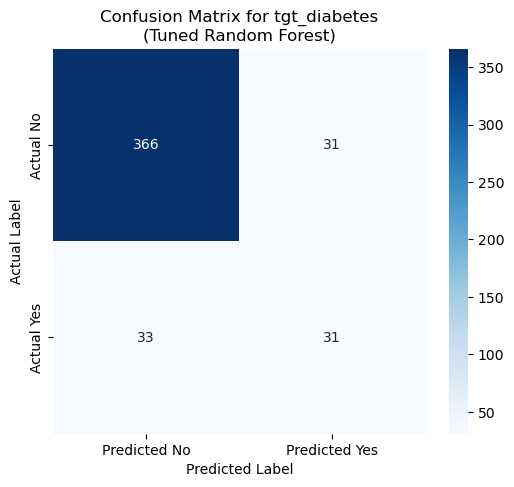

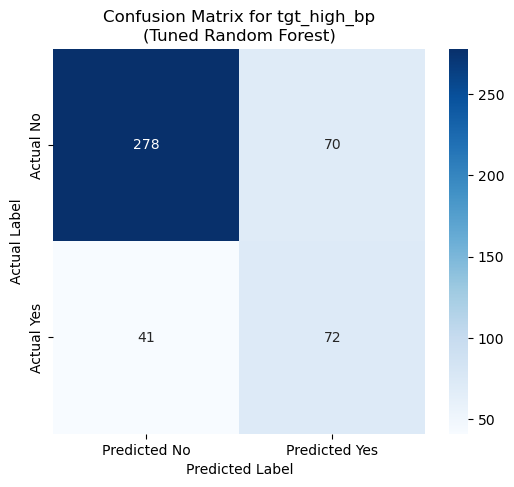

--- Confusion Matrices for: XGBoost ---


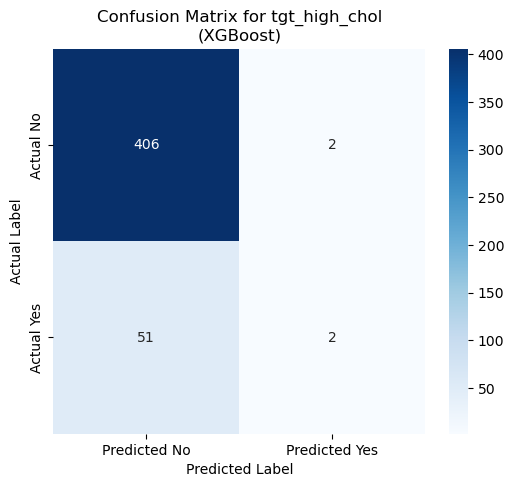

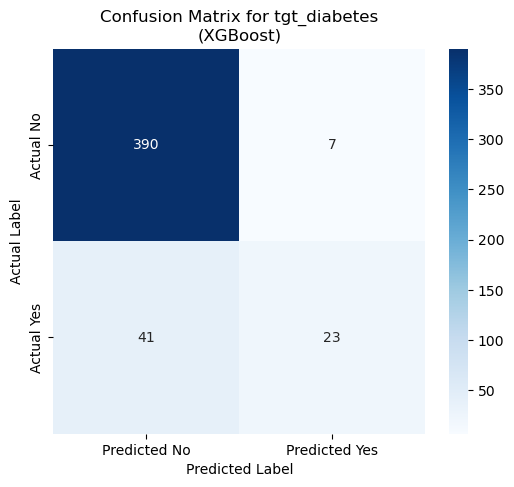

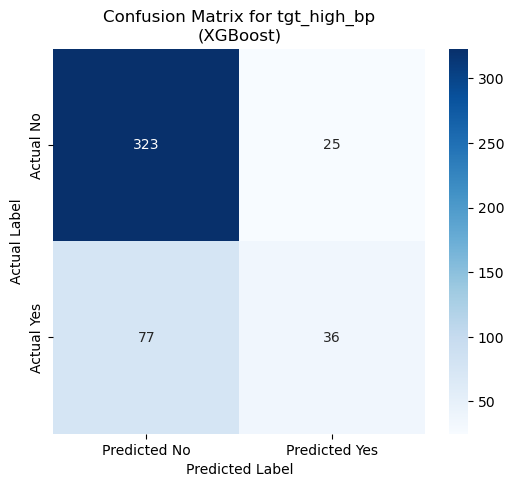

In [88]:
# - Looping through each model to generate plots -
for model_name, model in final_models.items():
    print(f'--- Confusion Matrices for: {model_name} ---')
    
    # making predictions on the test set
    y_pred = model.predict(X_test)
    
    # looping through each target variable to create a separate confusion matrix
    for i, target_name in enumerate(target_cols):
        
        # get the true labels and predicted labels for this specific target
        true_labels = y_test[target_name]
        predicted_labels = y_pred[:, i]
        
        # calculating the confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        
        # creating the plot
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted No', 'Predicted Yes'], 
                    yticklabels=['Actual No', 'Actual Yes'])
        plt.title(f'Confusion Matrix for {target_name}\n({model_name})')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        
        clean_model_name = model_name.replace(' ', '_')
        plt.savefig(f'confusion_matrix_{target_name}_{clean_model_name}.png', dpi=300, bbox_inches='tight')
        
        plt.show()

### ROC Curves and AUC Scores for All Models

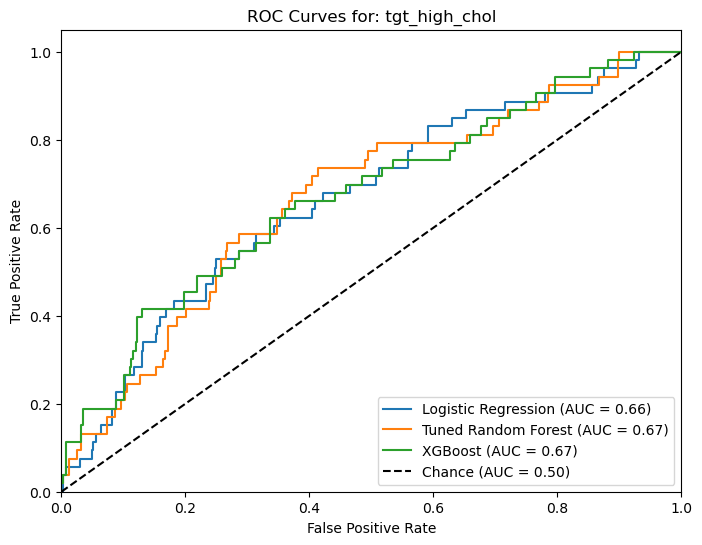

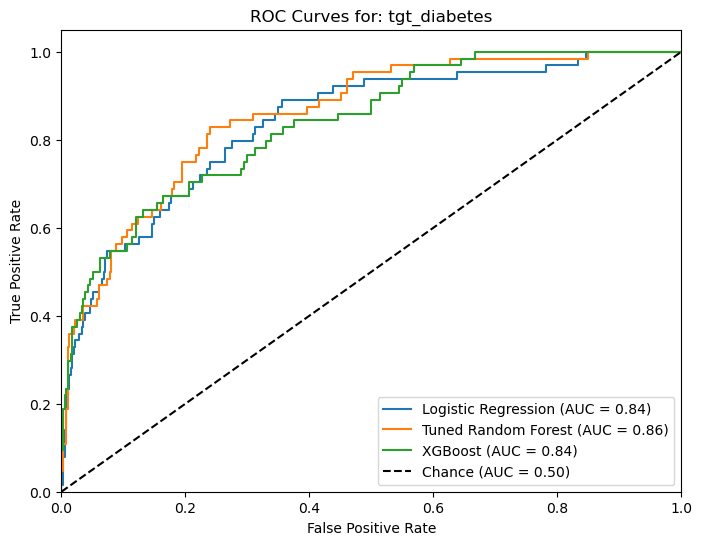

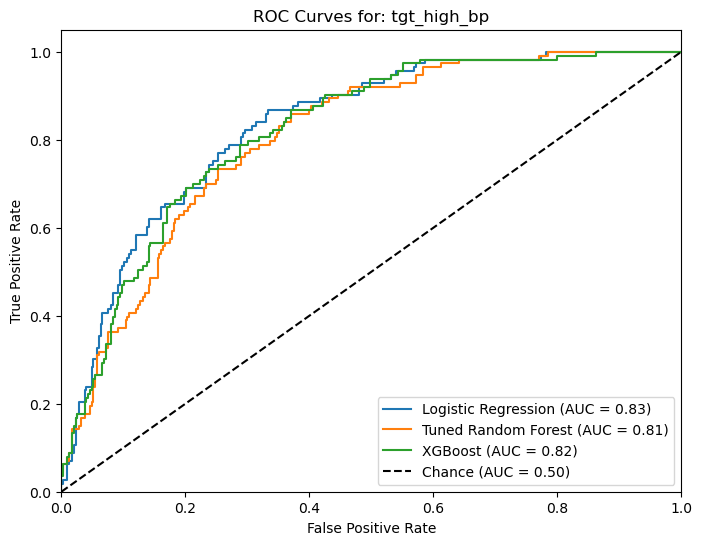

In [90]:
# --- Loop through each target variable to create a separate plot ---
for i, target_name in enumerate(target_cols):
    
    plt.figure(figsize=(8, 6))
    
    # - Looping through each model to plot its ROC curve -
    for model_name, model in final_models.items():
        
        # getting the prediction probabilities for class 1
        y_pred_proba = model.predict_proba(X_test)[i][:, 1]
        
        # calculating the ROC curve points
        fpr, tpr, _ = roc_curve(y_test[target_name], y_pred_proba)
        
        # calculating the AUC score
        roc_auc = auc(fpr, tpr)
        
        # ploting the ROC curve for the current model
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    #plotting the chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    
    # adding labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for: {target_name}')
    plt.legend(loc='lower right')
    
    # Save the plot
    clean_target_name = target_name.replace(' ', '_')
    plt.savefig(f'roc_curve_{clean_target_name}.png', dpi=300, bbox_inches='tight')
    
    plt.show()

## Feature Importance

### Random Forest Feature Importance

In [93]:
# extracting the individual random forest models from the wrapper
rf_models = final_rf_model.estimators_

In [94]:
# getting the feature importances from each of the three trained models
importances_per_target = [est.feature_importances_ for est in rf_models]

In [95]:
# calculating the mean importance for each feature across all three models
mean_importances = np.mean(importances_per_target, axis=0)

In [96]:
# creating a dataframe for visualisation and analysis
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

C:\Users\bianc\AppData\Local\Temp\ipykernel_4536\3071404512.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


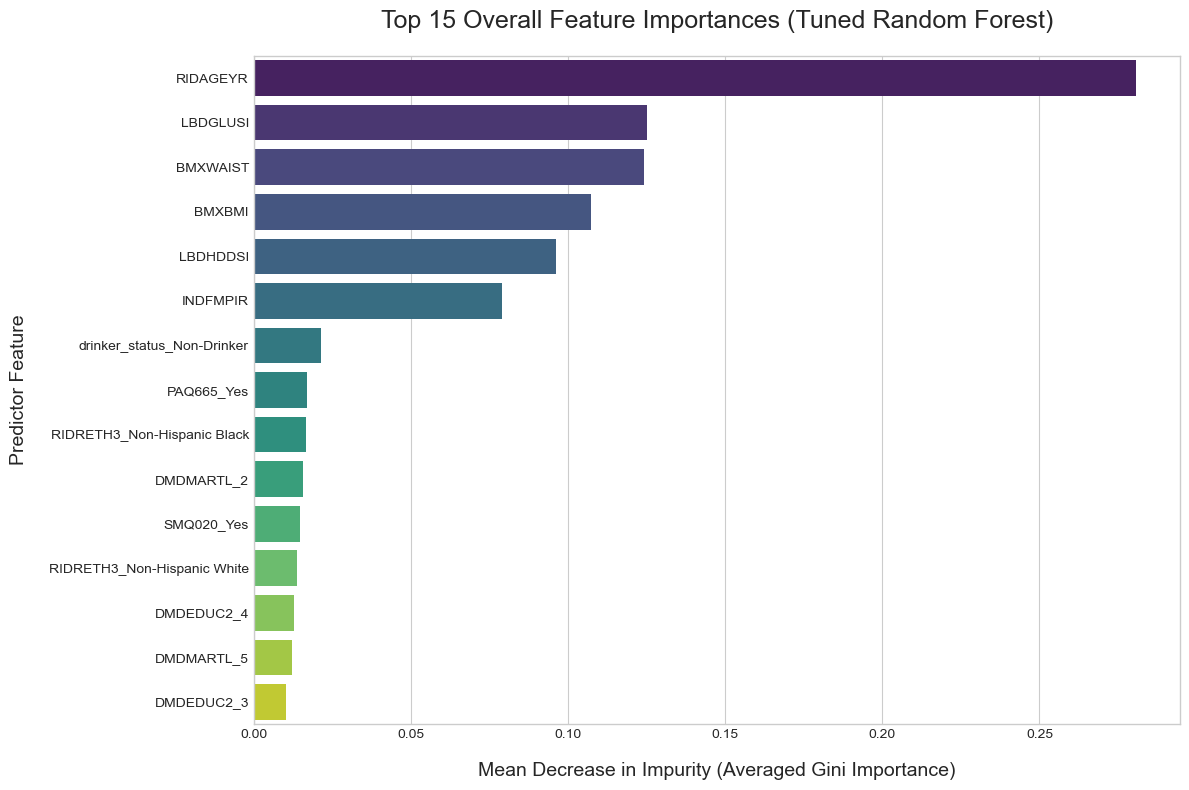

In [97]:
# creating a bar plot to visualise the top 15 features
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    x='Importance',
    y='Feature',
    data=rf_importance_df.head(15),
    palette='viridis',
    ax=ax
)

ax.set_title('Top 15 Overall Feature Importances (Tuned Random Forest)', fontsize=18, pad=20)
ax.set_xlabel('Mean Decrease in Impurity (Averaged Gini Importance)', fontsize=14, labelpad=15)
ax.set_ylabel('Predictor Feature', fontsize=14, labelpad=15)

plt.tight_layout()
plt.savefig('feature_importance_rf_overall.png', dpi=300, bbox_inches='tight')
plt.show()

### XGBoost Feature Importance

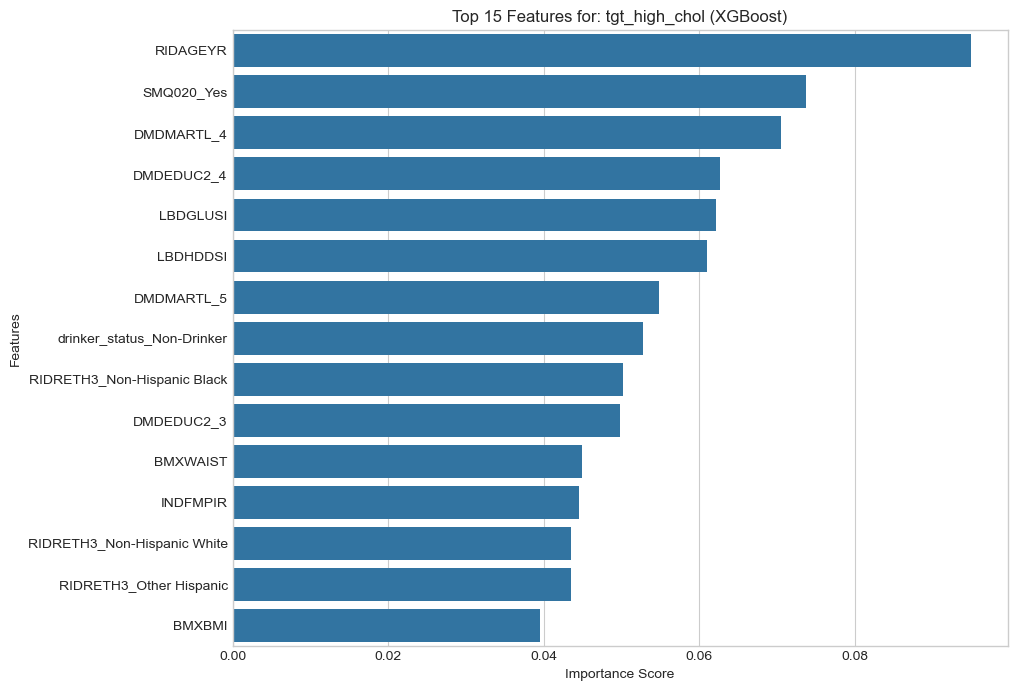

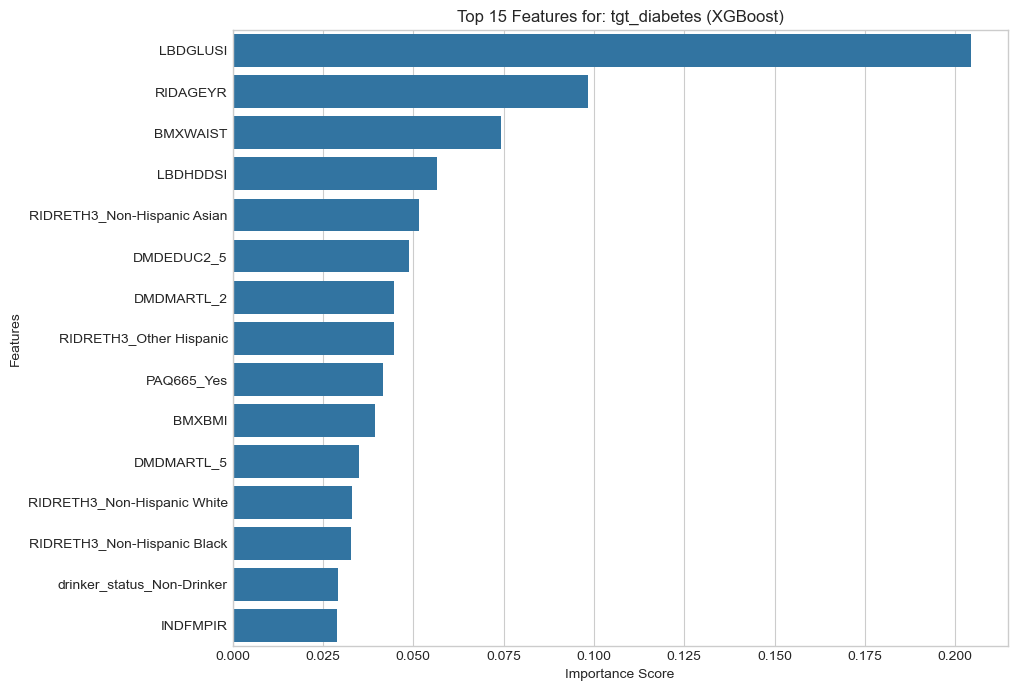

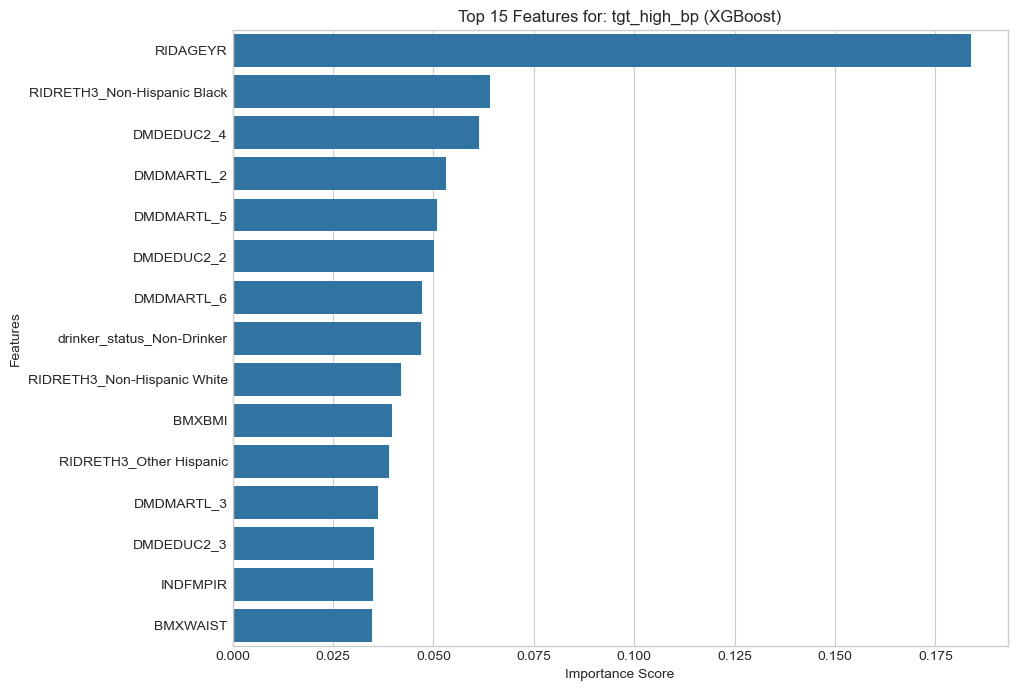

In [99]:
# analysing the feature importances from the trained XGBoost model
xgb_model = models['XGBoost']

# looping through each of the 3 estimators one for each target in the multioutput model
for i, target_name in enumerate(target_cols):
    
    individual_model = xgb_model.estimators_[i]
    
    importances = individual_model.feature_importances_
    
    feature_importances = pd.Series(importances, index=X_train.columns)
    
    # sorting the features by importance
    sorted_importances = feature_importances.sort_values(ascending=False)
    
    # - creating a plot for the current target -
    plt.figure(figsize=(10, 8))
    sns.barplot(x=sorted_importances.head(15), y=sorted_importances.head(15).index)
    plt.title(f'Top 15 Features for: {target_name} (XGBoost)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    
    # --- Save the plot ---
    clean_model_name = 'XGBoost'
    plt.savefig(f'feature_importance_{target_name}_{clean_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Logistic Regression Coefficient Analysis

In [101]:
# extracting the individual logistic regression models
lr_models = lr_scaled_model.estimators_

In [102]:
# getting the feature names from the X_train dataframe
feature_names = X_train.columns

In [103]:
# creating a dictionary to store the coefficients for each target
coefficients_dict = {}
for i, model in enumerate(lr_models):
    target_name = target_cols[i]
    coefficients_dict[target_name] = model.coef_[0]

In [104]:
# creating a dataframe from the dictionary to view
coef_df = pd.DataFrame(coefficients_dict, index=feature_names)

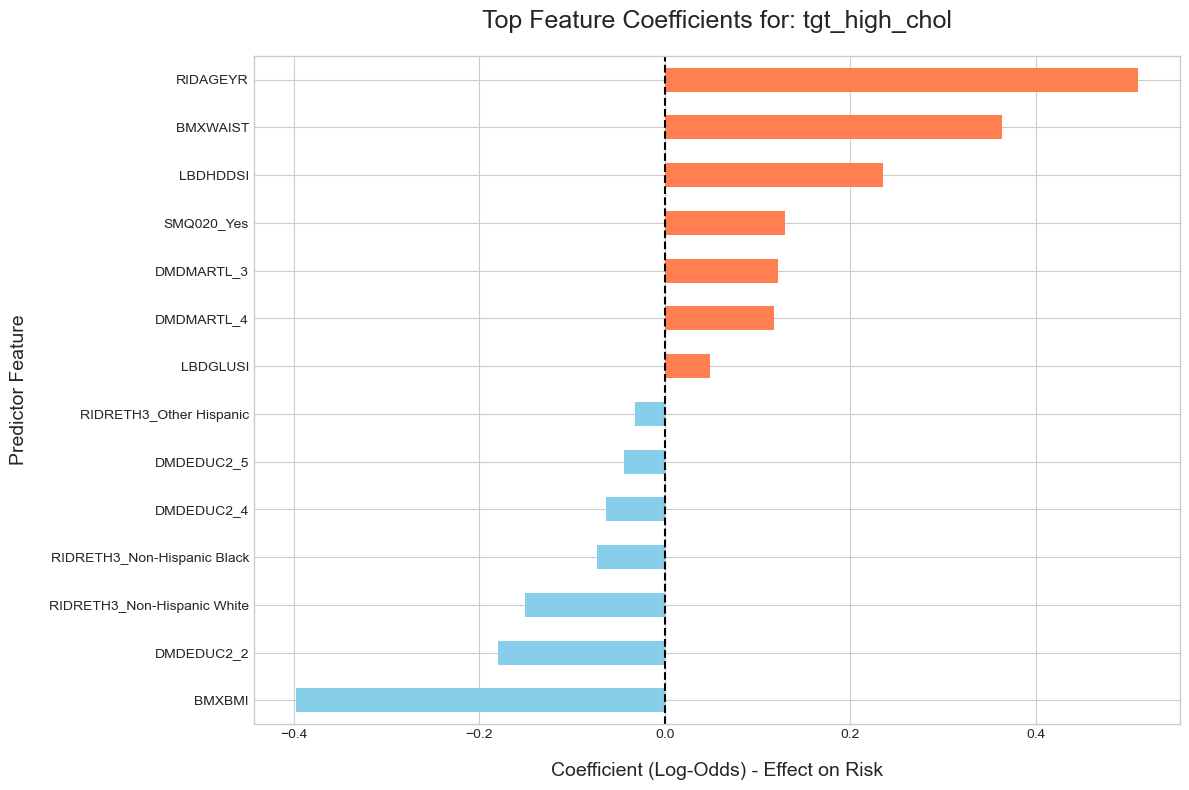

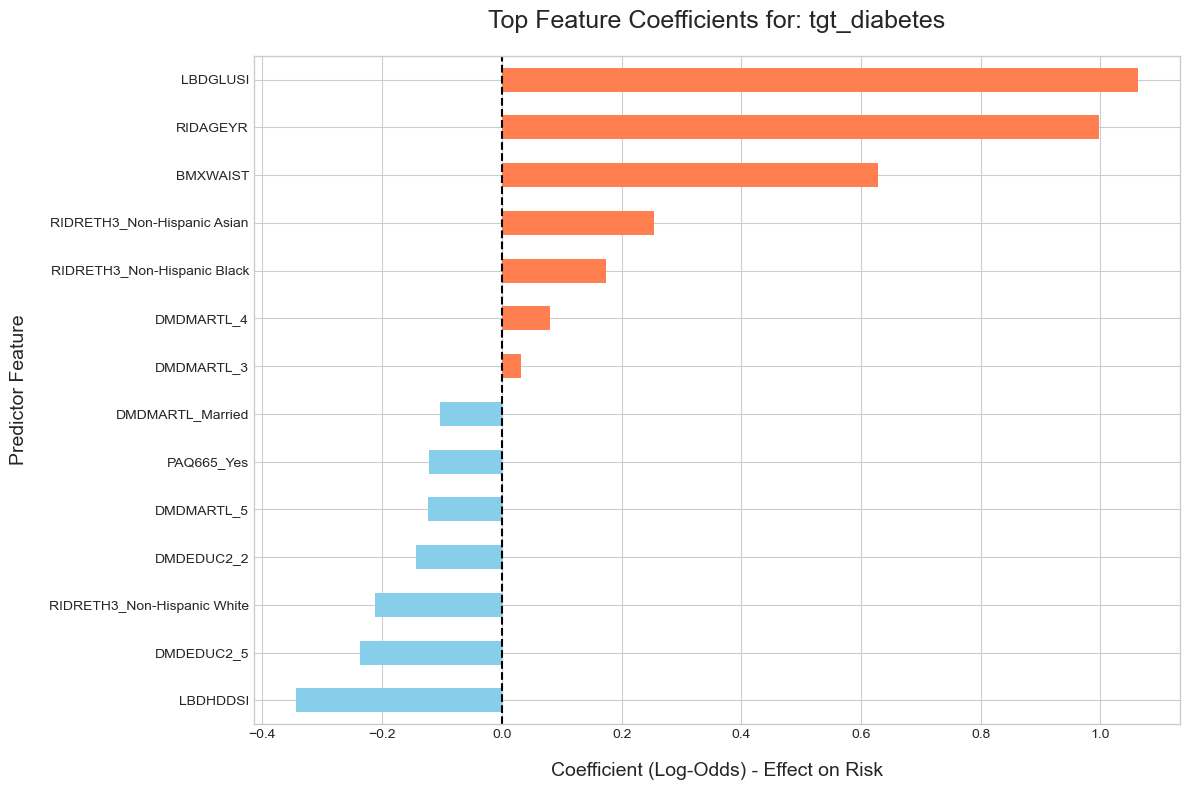

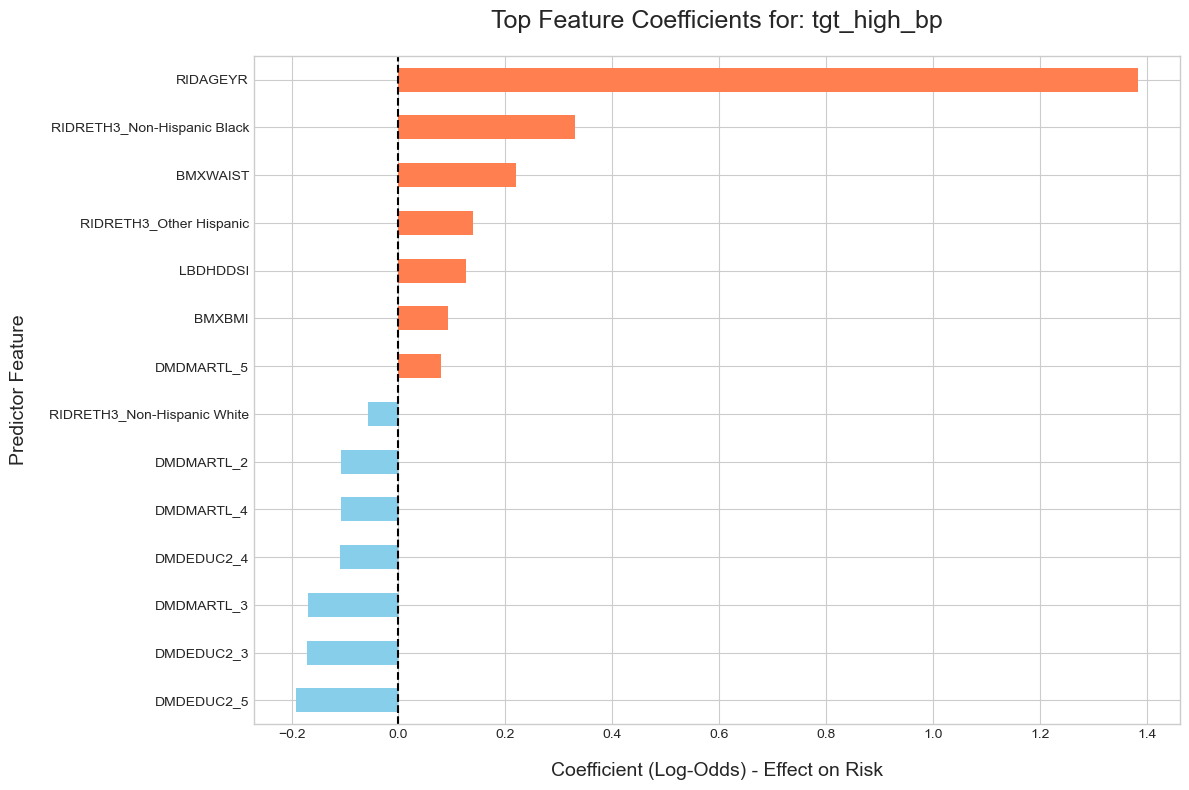

In [105]:
# calculatin the odds ratios by taking the exponent of the coefficients
# odds ratio > 1 is a risk factor odds ratio < 1 is a protective factor
odds_ratios_df = np.exp(coef_df)

# looping through each target outcome to create a separate plot for its coefficients
for target_name in target_cols:
    
    # getting the coefficients for the current target and sort them
    tgt_coefs = coef_df[target_name].sort_values()
    
    # selectinng the top 7 negative (protective) and top 7 positive (risk) factors
    top_coefs = pd.concat([tgt_coefs.head(7), tgt_coefs.tail(7)])
    
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_coefs.plot(kind='barh', ax=ax, color=(top_coefs > 0).map({True: 'coral', False: 'skyblue'}))
    
    ax.set_title(f'Top Feature Coefficients for: {target_name}', fontsize=18, pad=20)
    ax.set_xlabel('Coefficient (Log-Odds) - Effect on Risk', fontsize=14, labelpad=15)
    ax.set_ylabel('Predictor Feature', fontsize=14, labelpad=15)
    
    # adding a vertical line at 0 for reference
    ax.axvline(0, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'coefficient_plot_logreg_{target_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

### SHAP Analysis: Preparation

In [107]:
# preparing data for SHAP analysis

# creating copies of the training and test feature sets
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()

# identifying boolean columns in the training data
bool_cols = X_train_shap.select_dtypes(include='bool').columns

# converting boolean columns to integers (0 or 1)
X_train_shap[bool_cols] = X_train_shap[bool_cols].astype(int)
X_test_shap[bool_cols] = X_test_shap[bool_cols].astype(int)

# ensuring all columns are numeric and handle missing values
for col in X_train_shap.columns:
    # convert to numeric forcing non-numeric to NaN
    X_train_shap[col] = pd.to_numeric(X_train_shap[col], errors='coerce')
    X_test_shap[col] = pd.to_numeric(X_test_shap[col], errors='coerce')

    # using the median from the training data to fill NaNs to avoid data leakage
    median_val = X_train_shap[col].median()
    X_train_shap[col].fillna(median_val, inplace=True)
    X_test_shap[col].fillna(median_val, inplace=True)

# confirming all columns are numeric
print(X_train_shap.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1840 entries, 1721 to 1950
Data columns (total 25 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   RIDAGEYR                                      1840 non-null   int64  
 1   INDFMPIR                                      1840 non-null   float64
 2   BMXBMI                                        1840 non-null   float64
 3   BMXWAIST                                      1840 non-null   float64
 4   LBDHDDSI                                      1840 non-null   float64
 5   LBDGLUSI                                      1840 non-null   float64
 6   DMDEDUC2_2                                    1840 non-null   int32  
 7   DMDEDUC2_3                                    1840 non-null   int32  
 8   DMDEDUC2_4                                    1840 non-null   int32  
 9   DMDEDUC2_5                                    1840 non-null   int

C:\Users\bianc\AppData\Local\Temp\ipykernel_4536\414104161.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_shap[col].fillna(median_val, inplace=True)
C:\Users\bianc\AppData\Local\Temp\ipykernel_4536\414104161.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [108]:
warnings.filterwarnings('ignore')
# creating background dataset for SHAP explainer
bg_sample = X_train_shap.sample(min(100, len(X_train_shap)), random_state=42)

### SHAP Analysis: Tuned Random Forest

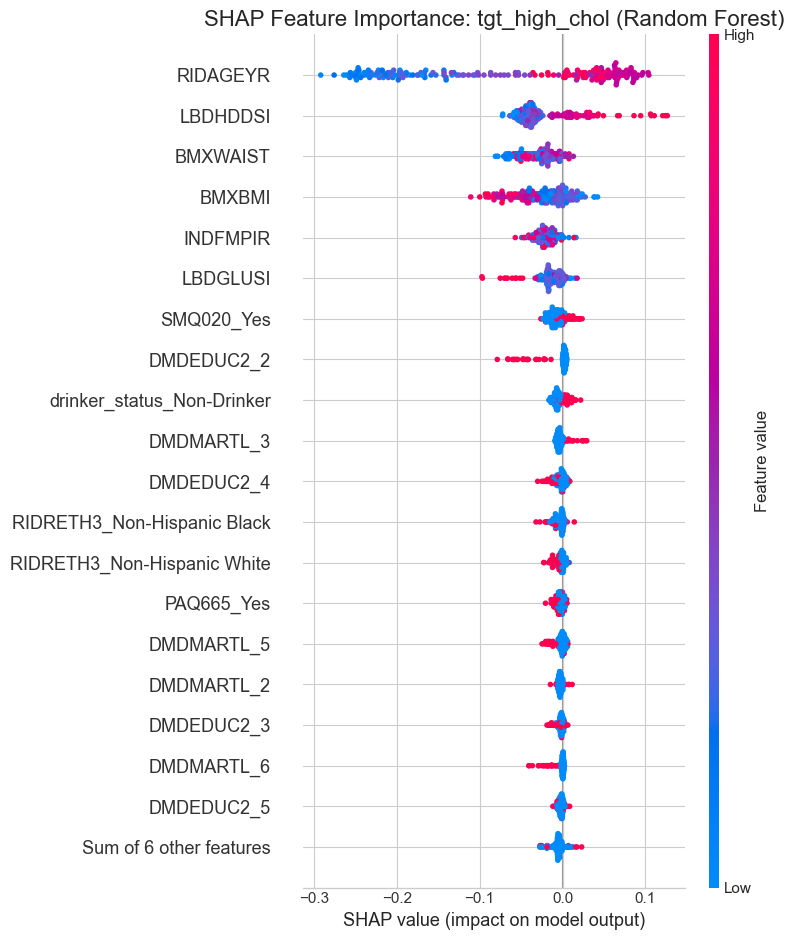

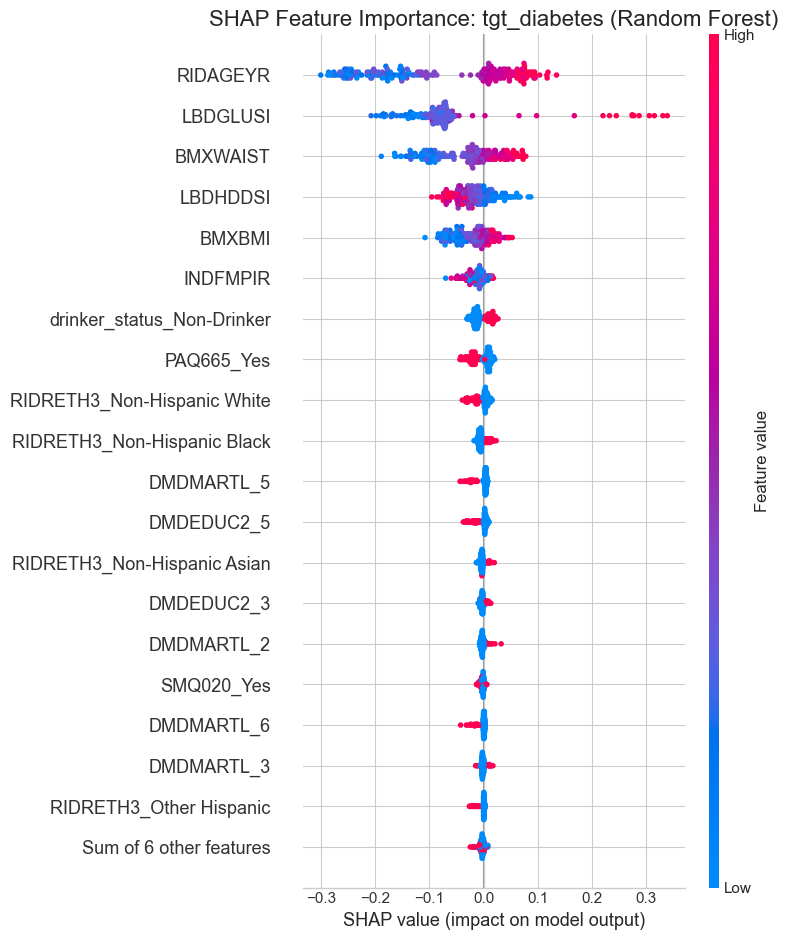

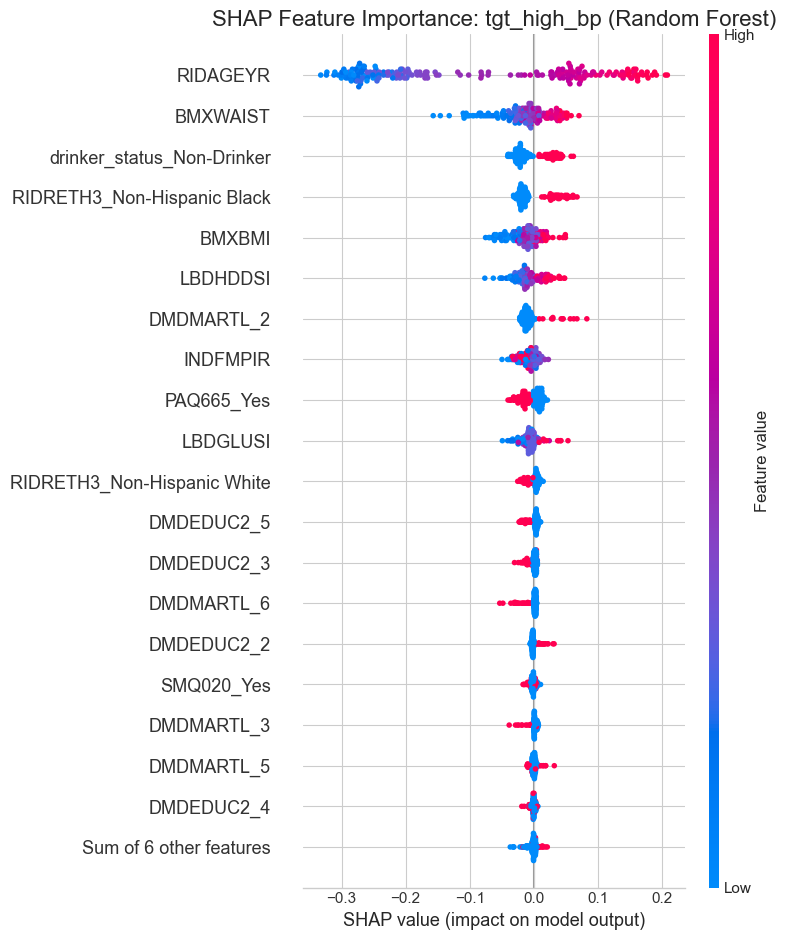

In [110]:
# looping through each target in the multi label set up 
for i, target_name in enumerate(target_cols):
    
    rf_est = final_rf_model.estimators_[i] 
    explainer = shap.TreeExplainer(rf_est)

    test_sample = X_test_shap.sample(min(200, len(X_test_shap)), random_state = 42)
    shap_values = explainer(test_sample)

    # handle binary classification
    if hasattr(shap_values, 'values') and shap_values.values.ndim == 3:
        shap_values.values = shap_values.values[:, :, 1]
        if hasattr(shap_values, 'base_values'):
            shap_values.base_values = shap_values.base_values[:, 1]

    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_values, max_display=20, show=False)
    plt.title(f'SHAP Feature Importance: {target_name} (Random Forest)', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'shap_summary_{target_name}_rf.png', dpi=300, bbox_inches='tight')
    plt.show()

### SHAP Analysis: XGBoost

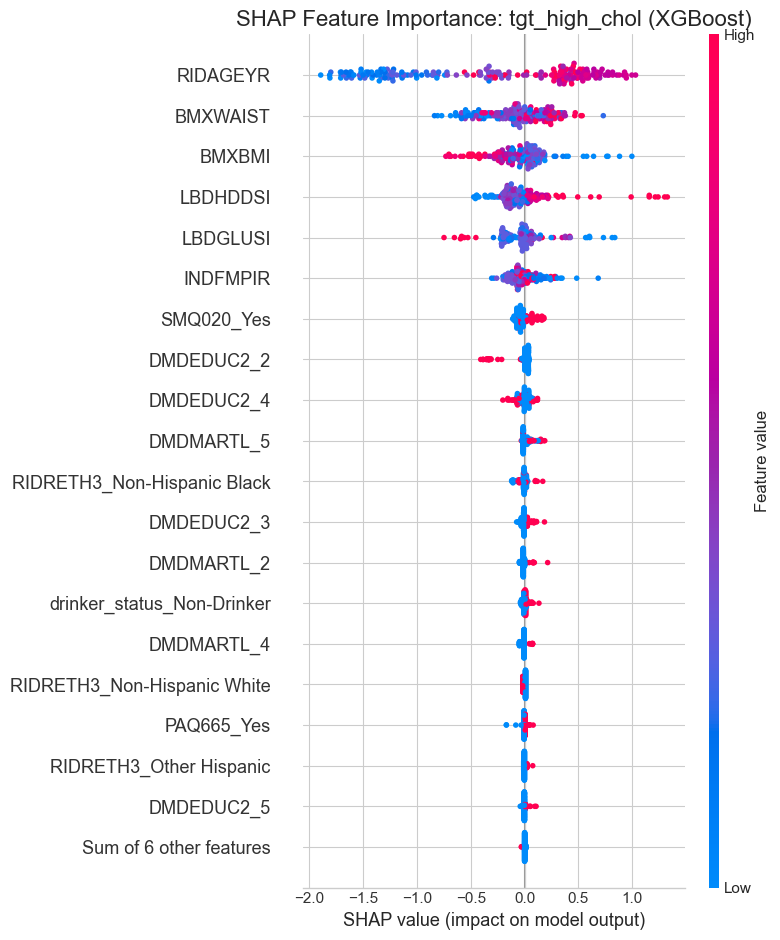

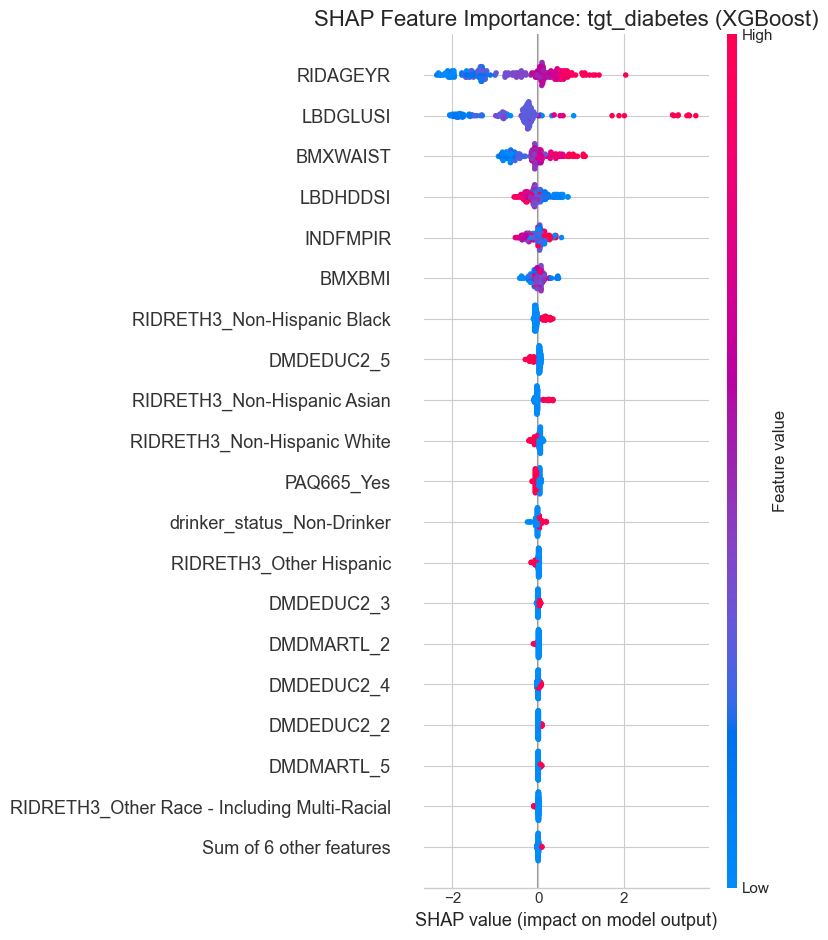

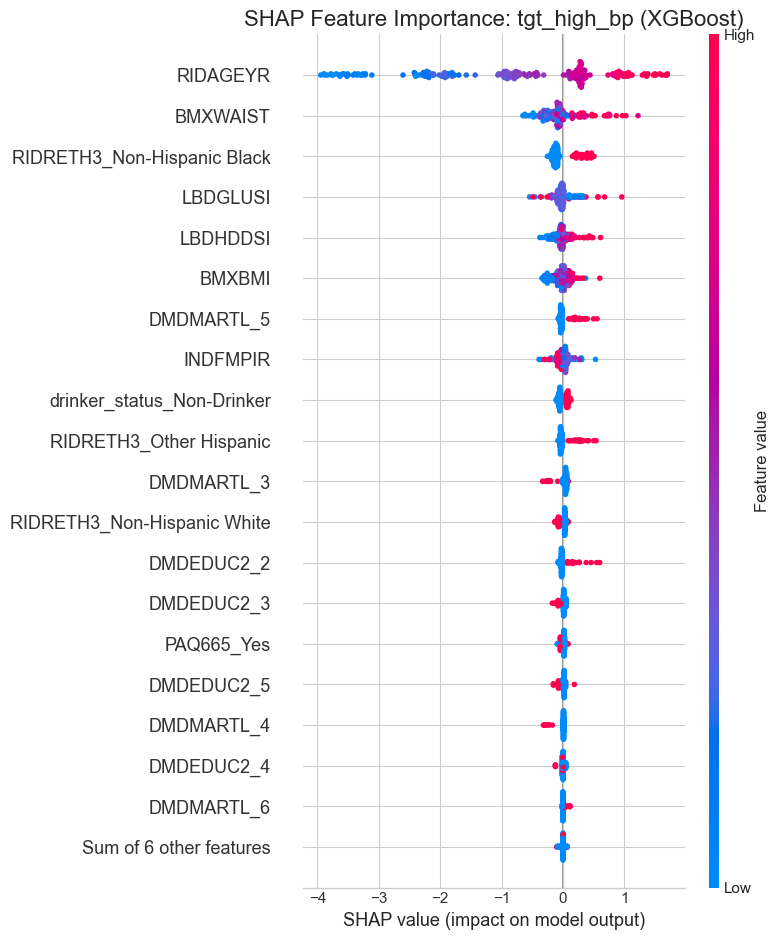

In [112]:
# looping through each target in the multi label set up 
xgb_multi = models['XGBoost']
for i, target_name in enumerate(target_cols):
    
    xgb_est = xgb_multi.estimators_[i] 
    explainer = shap.TreeExplainer(xgb_est)

    test_sample = X_test_shap.sample(min(200, len(X_test_shap)), random_state = 42)
    shap_values = explainer(test_sample)

    # handle binary classification
    if hasattr(shap_values, 'values') and shap_values.values.ndim == 3:
        shap_values.values = shap_values.values[:, :, 1]
        if hasattr(shap_values, 'base_values'):
            shap_values.base_values = shap_values.base_values[:, 1]

    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_values, max_display=20, show=False)
    plt.title(f'SHAP Feature Importance: {target_name} (XGBoost)', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'shap_summary_{target_name}_xgb.png', dpi=300, bbox_inches='tight')
    plt.show()

## Secondary Analysis of Elevated Glucose

In [114]:
# creating the Fasting Subsample data frame 
# must re-load the original data to ensure the 'tgt_high_glucose'column is present
# as it was dropped from the main data frame in the primary analysis.
womens_cmr_df_original = pd.read_csv('final_cmr_data.csv')
fasting_df = womens_cmr_df_original.dropna(subset=['tgt_high_glucose'])
print(f'Shape of the fasting subsample: {fasting_df.shape}')

Shape of the fasting subsample: (1262, 19)


In [115]:
# categorical encoding of the fasting subsample data 
categorical_cols = ['DMDEDUC2', 'DMDMARTL', 'RIDRETH3', 'SMQ020', 'drinker_status', 'PAQ665']
fasting_df_encoded = pd.get_dummies(fasting_df, columns=categorical_cols, drop_first=True)

In [116]:
# defining features X_fasting and target y_fasting
# the target is now just the single 'tgt_high_glucose' column
y_fasting = fasting_df_encoded['tgt_high_glucose']

In [117]:
# the features are all other columns excluding the other original targets
leak_cols = ['LBDGLUSI'] # defining the leaky variable for glucose
target_cols_to_drop = ['tgt_high_chol', 'tgt_diabetes', 'tgt_high_bp', 'tgt_high_glucose']
X_fasting = fasting_df_encoded.drop(columns=target_cols_to_drop + leak_cols)

In [119]:
# confirming the leaky variable is removed
print('\nVerifying columns in the final feature set (X_fasting):')
print(X_fasting.columns)


Verifying columns in the final feature set (X_fasting):
Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BPXSY2', 'BPXDI2',
       'LBDTCSI', 'LBDHDDSI', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDEDUC2_5', 'DMDMARTL_2', 'DMDMARTL_3', 'DMDMARTL_4', 'DMDMARTL_5',
       'DMDMARTL_6', 'RIDRETH3_Non-Hispanic Asian',
       'RIDRETH3_Non-Hispanic Black', 'RIDRETH3_Non-Hispanic White',
       'RIDRETH3_Other Hispanic',
       'RIDRETH3_Other Race - Including Multi-Racial', 'SMQ020_Yes',
       'drinker_status_Non-Drinker', 'PAQ665_Yes'],
      dtype='object')


In [121]:
# splitting the data into training and testing sets
X_train_fasting, X_test_fasting, y_train_fasting, y_test_fasting = train_test_split(
    X_fasting, y_fasting, test_size=0.2, random_state=42, stratify=y_fasting)

In [122]:
# training the final tuned Random Forest model
# using the best parameters found from GridSearchCV
final_glucose_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

final_glucose_model.fit(X_train_fasting, y_train_fasting)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [123]:
# evaluating the model
print('\n--- Final Evaluation: Elevated Glucose Model')
y_pred_glucose = final_glucose_model.predict(X_test_fasting)

# printing the classification report
print('Classification Report:')
print(classification_report(y_test_fasting, y_pred_glucose))

# printing the AUC score
y_pred_proba_glucose = final_glucose_model.predict_proba(X_test_fasting)[:, 1]
auc_glucose = roc_auc_score(y_test_fasting, y_pred_proba_glucose)
print(f'AUC Score for Elevated Glucose: {auc_glucose:.4f}')


--- Final Evaluation: Elevated Glucose Model
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       216
         1.0       0.38      0.30      0.33        37

    accuracy                           0.83       253
   macro avg       0.63      0.61      0.62       253
weighted avg       0.81      0.83      0.82       253

AUC Score for Elevated Glucose: 0.7675


### Elevated Glucose Feature Importance

In [125]:
# getting the feature importances from the trained model
glucose_importances = final_glucose_model.feature_importances_

In [126]:
# creating a dataframe for visualisation and analysis
glucose_importance_df = pd.DataFrame({
    'Feature': X_train_fasting.columns,
    'Importance': glucose_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

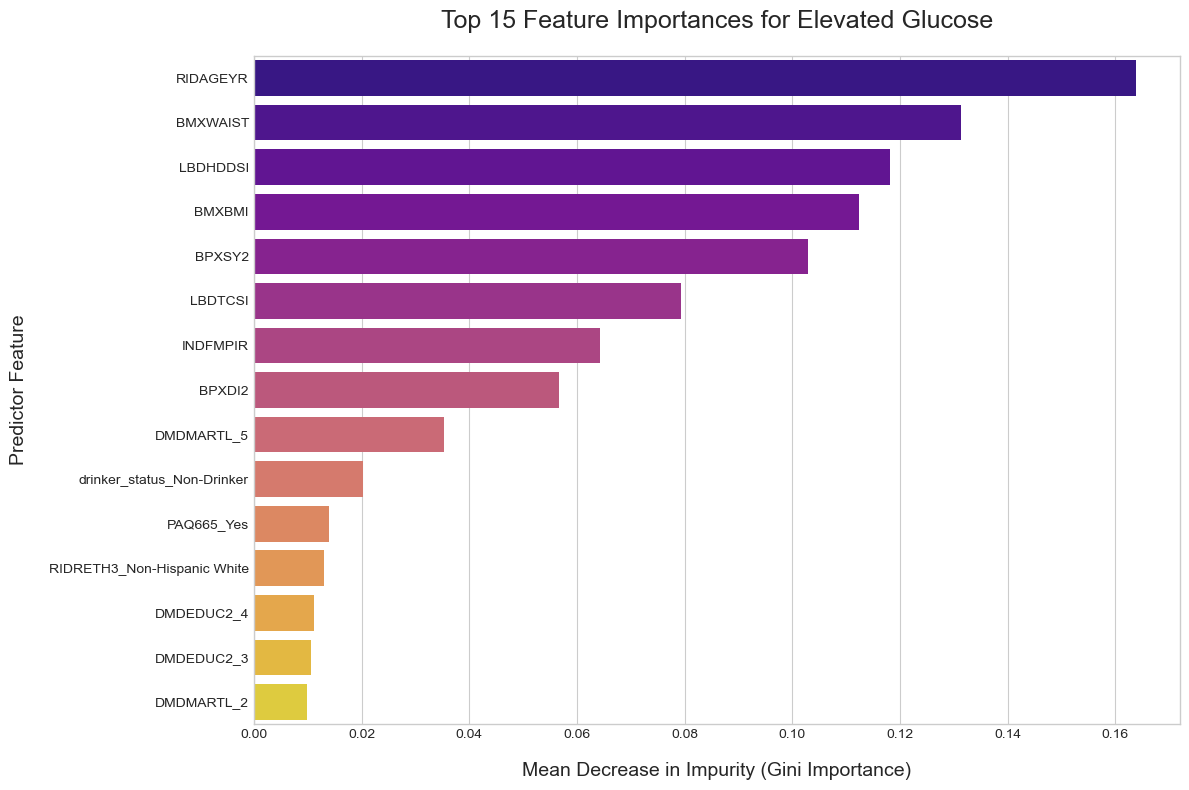

In [138]:
# creating a bar plot to visualise the top 15 features
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    x='Importance',
    y='Feature',
    data=glucose_importance_df.head(15),
    palette='plasma',
    ax=ax
)

ax.set_title('Top 15 Feature Importances for Elevated Glucose', fontsize=18, pad=20)
ax.set_xlabel('Mean Decrease in Impurity (Gini Importance)', fontsize=14, labelpad=15)
ax.set_ylabel('Predictor Feature', fontsize=14, labelpad=15)

plt.tight_layout()
plt.savefig('ft_imp_glucose_rf.png', dpi=300, bbox_inches='tight')
plt.show()

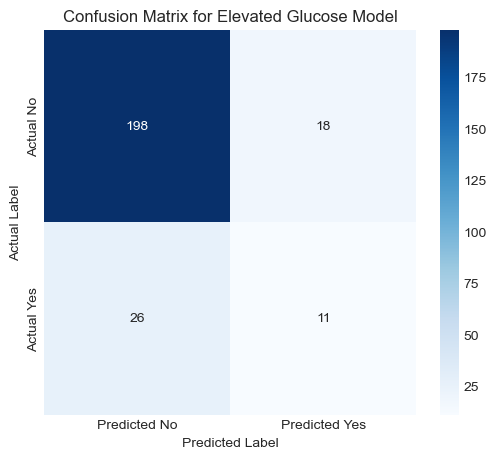

In [128]:
# visualising random forest confusion matrix
cm_glucose = confusion_matrix(y_test_fasting, y_pred_glucose)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_glucose, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'], 
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Elevated Glucose Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_glucose.png', dpi=300, bbox_inches='tight')
plt.show()

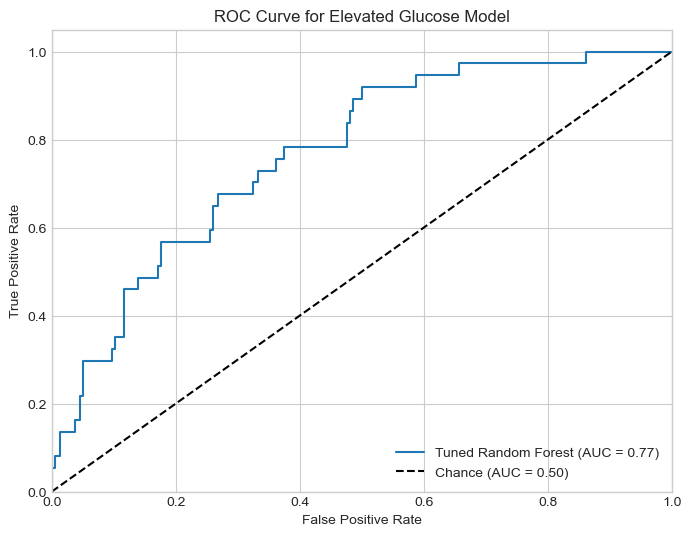

In [140]:
# visualising the ROC Curve
fpr, tpr, _ = roc_curve(y_test_fasting, y_pred_proba_glucose)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Random Forest (AUC = {auc_glucose:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Elevated Glucose Model')
plt.legend(loc='lower right')
plt.savefig('roc_curve_glucose_RF.png', dpi=300, bbox_inches='tight')
plt.show()